In [3]:
# Load libraries

import pandas as pd
import numpy as np

import string
import re

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from collections import Counter
from collections import defaultdict
from tqdm import tqdm

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

import emoji
import regex

In [4]:
# Loading Dataset

pd.set_option('display.max_rows', None)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
print(train.head(2))
print(test.head(2))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   

   target  
0       1  
1       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
# Unique keywords and Locations

print('Train')
for col in ['location', 'keyword']:
    print(col, train[col].nunique())
print('###')
print('Test')
for col in ['location', 'keyword']:
    print(col, test[col].nunique())

Train
location 3341
keyword 221
###
Test
location 1602
keyword 221


In [9]:
# EDA

In [10]:
print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


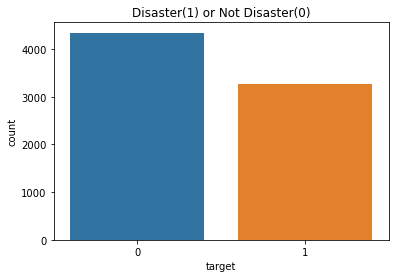

In [11]:
# Number of real and fake disaster tweets 

sns.countplot(x="target", data=train)
plt
plt.title("Disaster(1) or Not Disaster(0)")
plt.show()

<AxesSubplot:>

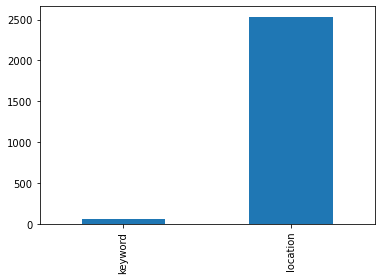

In [12]:
# Cheking for null values

null = train.isnull().sum()
null = null[null > 0]
null.sort_values(inplace=True)
null.plot.bar()

In [13]:
# the 20 most common locations

location = train['location'].value_counts().head(20).rename_axis('location').reset_index(name='counts')
location_list = location['location'].tolist()

df_location = train[train.location.isin(location_list)]

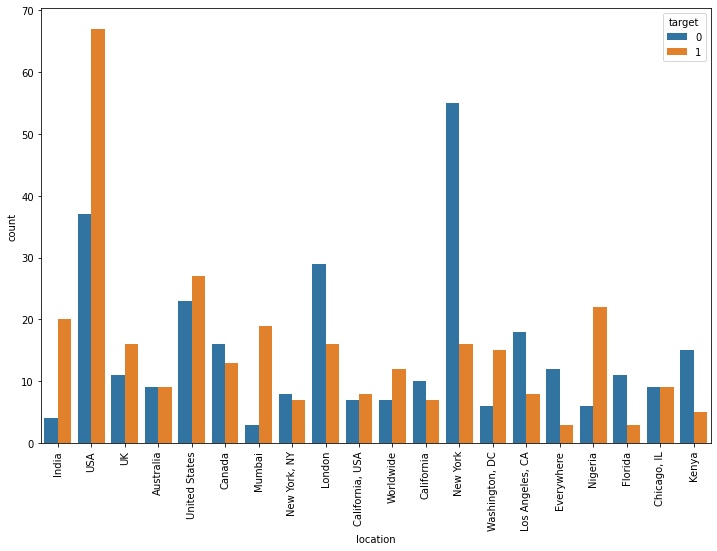

In [14]:
plt.figure(figsize = (12,8))

char = sns.countplot(x = "location", hue = "target" , data = df_location)
char.set_xticklabels(char.get_xticklabels(),rotation=90)
plt.show()

In [15]:
# the 20 most common keywords

keyword = train['keyword'].value_counts().head(20).rename_axis('keyword').reset_index(name='counts')
keyword_list = keyword['keyword'].tolist()

df_keyword = train[train.keyword.isin(keyword_list)]

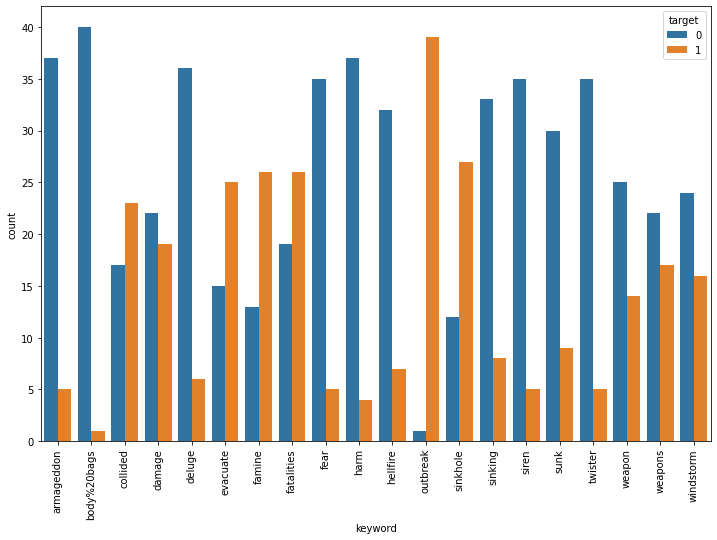

In [16]:
plt.figure(figsize = (12,8))

char = sns.countplot(x = "keyword", hue = "target" , data = df_keyword)
char.set_xticklabels(char.get_xticklabels(),rotation=90)
plt.show()

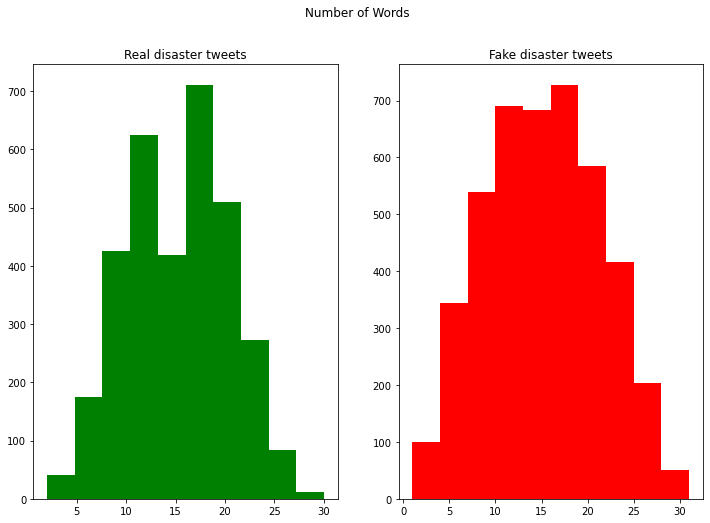

In [17]:
# Number os words in real and fake tweets

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=train[train.target == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Real disaster tweets')

text_len=train[train.target == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Fake disaster tweets')

fig.suptitle('Number of Words')
plt.show()

In [18]:
# Number os mentions @ 

def count_mention(text):
    words = text.split()
    
    mentions = [word for word in words if word.startswith('@')]
    return len(mentions)

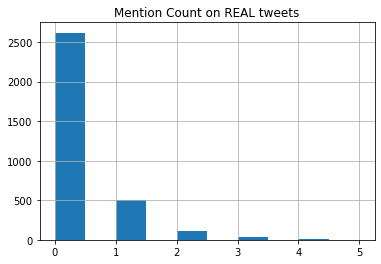

In [19]:
train[train['target'] == 1 ]['text'].apply(count_mention).hist()
plt.title('Mention Count on REAL tweets')
plt.show()

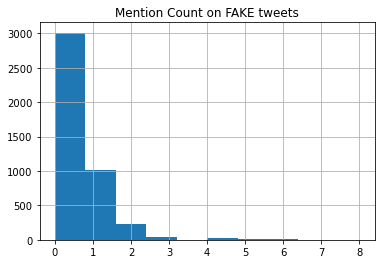

In [20]:
train[train['target'] == 0 ]['text'].apply(count_mention).hist()
plt.title('Mention Count on FAKE tweets')
plt.show()

In [21]:
# For a more compreenshible EDA a few steps need to be taken into consideration
# remove emojis
# all words to lower case
# spellchek
# remove pontuation
# remove htmls

In [22]:
# Counting emojis

In [23]:
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.distinct_emoji_list(text) for char in word):
            emoji_list.append(word)
    
    return emoji_list

In [24]:
text = train['text']
emoji_list= [] 
for t in text:
  emoji_list=emoji_list+split_count(t)

In [25]:
emoji_list

['©', '©', '©', '©', '©', '©', '©', '©', '©', '©']

In [26]:
# not many emojis

In [27]:
# remove emojis

def removing_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [28]:
train['text'] = train['text'].apply(removing_emoji)

In [29]:
# counting pontuaction per tweet

In [30]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

train['count_punct'] = train.text.apply(lambda s: count(s, string.punctuation))

In [31]:
train.head()

,id,keyword,location,text,target,count_punct
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,3
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,2
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,2


In [32]:
# remove pontuation and convert text to lower case

text_list = list(train['text'])

clear_text_list = [] 

for i in tqdm(range(len(text_list))):
    clear_text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',text_list[i])
    #re.sub 
    clear_text_list.append(clear_text.lower())
    #lower
    
train['clear_text'] = clear_text_list

100%|██████████| 7613/7613 [00:00<00:00, 345958.05it/s]


In [33]:
train.head()

,id,keyword,location,text,target,count_punct,clear_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,3,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,2,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,2,just got sent this photo from ruby alaska as s...


In [34]:
# spellcheking

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [35]:
train['clear_text_corrected'] = train['clear_text'].apply(correct_spellings)

In [36]:
train.head()

,id,keyword,location,text,target,count_punct,clear_text,clear_text_corrected
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,our deeds are the reason of this earthquake ma...,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,forest fire near la ronge sask canada,forest fire near la range ask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,3,all residents asked to shelter in place are be...,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,2,13000 people receive wildfires evacuation orde...,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,2,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby alaska as s...


In [37]:
# stopwords

stop = set(stopwords.words('english'))

In [38]:
# counting stopwords per tweet

train['stopwords'] = train['clear_text_corrected'].str.split().apply(lambda x: len(set(x) & stop))

<AxesSubplot:xlabel='stopwords', ylabel='Count'>

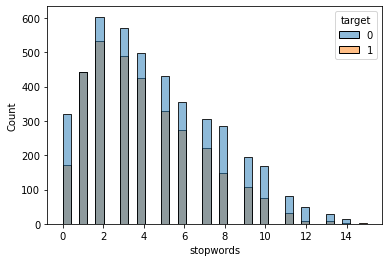

In [39]:
sns.histplot(data= train, x = 'stopwords', hue='target')

In [40]:
train.head()

,id,keyword,location,text,target,count_punct,clear_text,clear_text_corrected,stopwords
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,our deeds are the reason of this earthquake ma...,our deeds are the reason of this earthquake ma...,6
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,forest fire near la ronge sask canada,forest fire near la range ask canada,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,3,all residents asked to shelter in place are be...,all residents asked to shelter in place are be...,9
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,2,13000 people receive wildfires evacuation orde...,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,2,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby alaska as s...,6


In [41]:
# Common stopwords

def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
                words.append(j.strip())
    return words

    
corpus_real = get_corpus(train[train.target == 1].clear_text_corrected)
corpus_fake = get_corpus(train[train.target == 0].clear_text_corrected)

In [42]:
dic=defaultdict(int)
for word in corpus_real:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

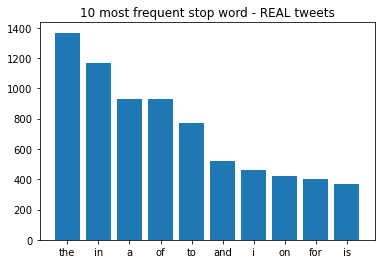

In [43]:
x,y=zip(*top)
plt.bar(x,y)
plt.title('10 most frequent stop word - REAL tweets')
plt.show()

In [44]:
dic=defaultdict(int)
for word in corpus_fake:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

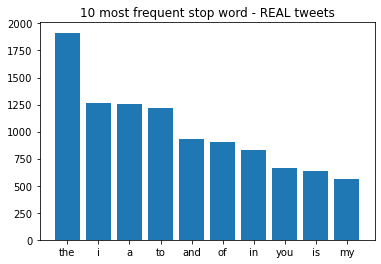

In [45]:
x,y=zip(*top)
plt.bar(x,y)
plt.title('10 most frequent stop word - REAL tweets')
plt.show()

In [46]:
# Common words

punctuation_list = string.punctuation

In [47]:
def common_words(target):
    word_list = []
    word_ammount = []

    for word, ammount in target[:50]:
        if( word not in stop and word not in punctuation_list):
            word_list.append(word)
            word_ammount.append(ammount)
            
    sns.barplot(x=word_ammount, y=word_list)

In [48]:
counter_real_stopword = Counter(corpus_real)
counter_fake_stopword = Counter(corpus_fake)

most_common_real_stopword = dict(counter_real_stopword)
most_common_fake_stopword = dict(counter_fake_stopword)

most_common_real_stopword = sorted(most_common_real_stopword.items(), key=lambda x:x[1], reverse=True)[:10]
most_common_fake_stopword = sorted(most_common_fake_stopword.items(), key=lambda x:x[1], reverse=True)[:10]

In [49]:
dic=defaultdict(int)
for word in corpus_real:
    if word not in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

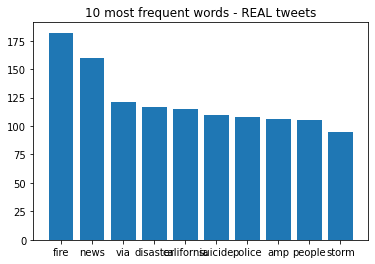

In [50]:
x,y=zip(*top)
plt.bar(x,y)
plt.title('10 most frequent words - REAL tweets')
plt.show()

In [51]:
dic=defaultdict(int)
for word in corpus_fake:
    if word not in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

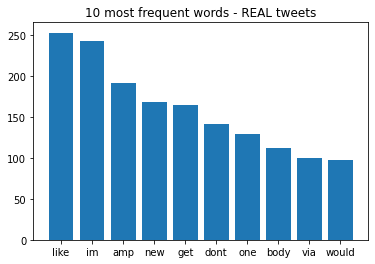

In [52]:
x,y=zip(*top)
plt.bar(x,y)
plt.title('10 most frequent words - REAL tweets')
plt.show()

In [53]:
# counting words per tweet

In [54]:
train['totalwords'] = train['clear_text_corrected'].str.split().str.len()

In [55]:
train.head()

,id,keyword,location,text,target,count_punct,clear_text,clear_text_corrected,stopwords,totalwords
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,our deeds are the reason of this earthquake ma...,our deeds are the reason of this earthquake ma...,6,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,forest fire near la ronge sask canada,forest fire near la range ask canada,0,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,3,all residents asked to shelter in place are be...,all residents asked to shelter in place are be...,9,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,2,13000 people receive wildfires evacuation orde...,13000 people receive wildfires evacuation orde...,1,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,2,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby alaska as s...,6,16


In [56]:
# worldclouds

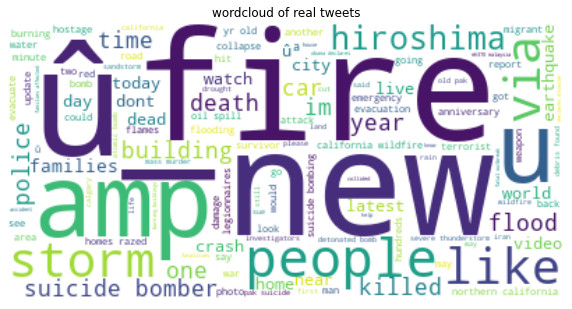

In [57]:
data_real = train[train['target']==1]

text = " ".join(i for i in data_real.clear_text_corrected)
#stopwords = stop
wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

plt.figure( figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('wordcloud of real tweets')
plt.axis("off")
plt.show()

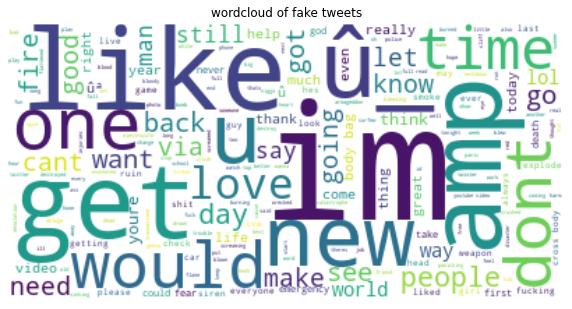

In [58]:
data_fake = train[train['target']==0]

text = " ".join(i for i in data_fake.clear_text_corrected)
#stopwords = stop
wordcloud = WordCloud(stopwords=stop, background_color="white").generate(text)

plt.figure( figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('wordcloud of fake tweets')
plt.axis("off")
plt.show()

In [59]:
# Feature engineering

In [60]:
train.head()

,id,keyword,location,text,target,count_punct,clear_text,clear_text_corrected,stopwords,totalwords
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,our deeds are the reason of this earthquake ma...,our deeds are the reason of this earthquake ma...,6,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,forest fire near la ronge sask canada,forest fire near la range ask canada,0,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,3,all residents asked to shelter in place are be...,all residents asked to shelter in place are be...,9,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,2,13000 people receive wildfires evacuation orde...,13000 people receive wildfires evacuation orde...,1,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,2,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby alaska as s...,6,16


In [61]:
# Making a new dataset

# new_train = pd.DataFrame(train[['id', 'keyword', 'location', 'stopwords', 'totalwords', 'clear_text_corrected', 'target']])

In [62]:
# Replacing missing values in keyword and location

train['keyword'] = train['keyword'].fillna('none')
train['location'] = train['location'].fillna('unknown')

train.isnull().sum()

id                      0
keyword                 0
location                0
text                    0
target                  0
count_punct             0
clear_text              0
clear_text_corrected    0
stopwords               0
totalwords              0
dtype: int64

In [63]:
# remove stopwords

train['clear_text_corrected'] = train['clear_text_corrected'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [64]:
train.head(5)

,id,keyword,location,text,target,count_punct,clear_text,clear_text_corrected,stopwords,totalwords
0,1,none,unknown,Our Deeds are the Reason of this #earthquake M...,1,1,our deeds are the reason of this earthquake ma...,deeds reason earthquake may allah forgive us,6,13
1,4,none,unknown,Forest fire near La Ronge Sask. Canada,1,1,forest fire near la ronge sask canada,forest fire near la range ask canada,0,7
2,5,none,unknown,All residents asked to 'shelter in place' are ...,1,3,all residents asked to shelter in place are be...,residents asked shelter place notified officer...,9,22
3,6,none,unknown,"13,000 people receive #wildfires evacuation or...",1,2,13000 people receive wildfires evacuation orde...,13000 people receive wildfires evacuation orde...,1,8
4,7,none,unknown,Just got sent this photo from Ruby #Alaska as ...,1,2,just got sent this photo from ruby alaska as s...,got sent photo ruby alaska smoke wildfires pou...,6,16


In [65]:
df_train = train[['keyword', 'location', 'stopwords', 'totalwords', 'count_punct', 'clear_text_corrected', 'target']]

In [66]:
df_train.head()

,keyword,location,stopwords,totalwords,count_punct,clear_text_corrected,target
0,none,unknown,6,13,1,deeds reason earthquake may allah forgive us,1
1,none,unknown,0,7,1,forest fire near la range ask canada,1
2,none,unknown,9,22,3,residents asked shelter place notified officer...,1
3,none,unknown,1,8,2,13000 people receive wildfires evacuation orde...,1
4,none,unknown,6,16,2,got sent photo ruby alaska smoke wildfires pou...,1


In [67]:
# Predictions

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

seed = 42

In [68]:
def confunsionMatrix (matrix):
  ax = sns.heatmap(matrix/np.sum(matrix), annot=True, 
              fmt='.2%', cmap='Reds')

  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order

  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])

  ## Display the visualization of the Confusion Matrix.
  
  plt.show()

In [69]:
X = df_train['keyword'] + ' ' + df_train['location'] + ' ' + df_train['stopwords'].apply(str) + ' ' + df_train['totalwords'].apply(str) + ' ' + df_train['count_punct'].apply(str) + ' ' + df_train['clear_text_corrected']
y = df_train['target']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed)

In [71]:
# try 1
# TfidfVectorizer + MultinomialNB

In [72]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
X_train_1 = tfidf_vectorizer.fit_transform(X_train)
X_test_1 = tfidf_vectorizer.transform(X_test)

In [73]:
clf = MultinomialNB()
parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]}

clf_NB = GridSearchCV(clf, parameters, cv = 5, n_jobs=-1).fit(X_train_1, y_train) #.toarray(), y_train)

In [74]:
predictions = clf_NB.predict(X_test_1) #.toarray())

In [75]:
f1_score(y_test, predictions)

0.7382169222032936

In [76]:
cm = metrics.confusion_matrix(y_test, predictions) 

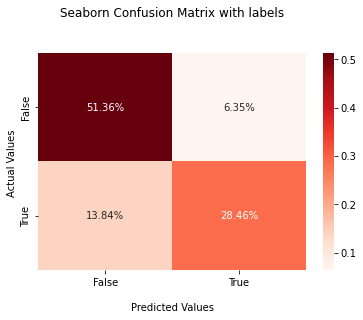

In [77]:
confunsionMatrix(cm)

In [78]:
report = classification_report(y_test, predictions, digits=5) # precision and recall and accuracy
print(report)

              precision    recall  f1-score   support

           0    0.78778   0.88998   0.83577      1318
           1    0.81761   0.67288   0.73822       966

    accuracy                        0.79816      2284
   macro avg    0.80269   0.78143   0.78699      2284
weighted avg    0.80039   0.79816   0.79451      2284



In [79]:
# try 2
# TfidfVectorizer + LogisticRegression

In [80]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
X_train_2 = tfidf_vectorizer.fit_transform(X_train)
X_test_2 = tfidf_vectorizer.transform(X_test)

In [81]:
clf = LogisticRegression(random_state = seed, max_iter = 1000)
parameters = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

clf_lr = GridSearchCV(clf, parameters, cv = 5, n_jobs=-1).fit(X_train_2, y_train) #.toarray(), y_train)

In [82]:
predictions = clf_lr.predict(X_test_2) #.toarray())

In [83]:
cm = metrics.confusion_matrix(y_test, predictions) 

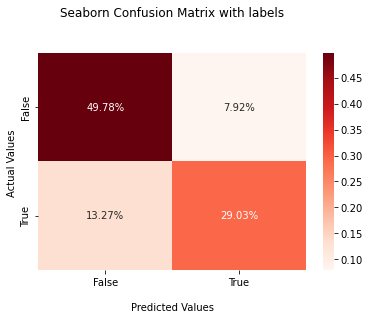

In [84]:
confunsionMatrix(cm)

In [85]:
report = classification_report(y_test, predictions, digits=5) # precision and recall and accuracy
print(report)

              precision    recall  f1-score   support

           0    0.78958   0.86267   0.82451      1318
           1    0.78555   0.68634   0.73260       966

    accuracy                        0.78809      2284
   macro avg    0.78756   0.77450   0.77855      2284
weighted avg    0.78788   0.78809   0.78564      2284



In [86]:
# try 3
# TfidfVectorizer + SVM

In [87]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
X_train_3 = tfidf_vectorizer.fit_transform(X_train)
X_test_3 = tfidf_vectorizer.transform(X_test)

In [88]:
svc = SVC(random_state = seed, probability = True, verbose = True)
parameters = {'C':[1,2,3,4,5,8,9,10], 'kernel': ['poly', 'rbf'], 'cache_size': [1000]}

clf_svc = GridSearchCV(svc, parameters, cv = 5, n_jobs=-1).fit(X_train_3, y_train) #.values.ravel())

[LibSVM]

In [89]:
predictions = clf_svc.predict(X_test_3) #.toarray())

In [90]:
cm = metrics.confusion_matrix(y_test, predictions) 

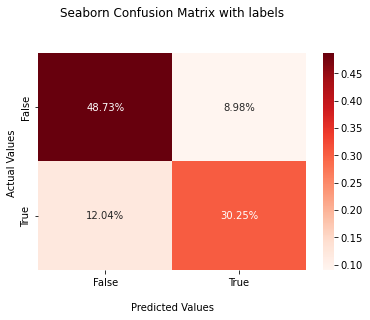

In [91]:
confunsionMatrix(cm)

In [92]:
report = classification_report(y_test, predictions, digits=5) # precision and recall and accuracy
print(report)

              precision    recall  f1-score   support

           0    0.80187   0.84446   0.82262      1318
           1    0.77121   0.71532   0.74221       966

    accuracy                        0.78984      2284
   macro avg    0.78654   0.77989   0.78241      2284
weighted avg    0.78890   0.78984   0.78861      2284



In [93]:
# try 4
# countvectorize + MultinomialNB

In [94]:
cv = CountVectorizer(stop_words = 'english')
X_train_4 = cv.fit_transform(X_train)
X_test_4 = cv.transform(X_test)

In [95]:
clf = MultinomialNB()
parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]}

clf_NB = GridSearchCV(clf, parameters, cv = 5, n_jobs=-1).fit(X_train_4, y_train)

In [96]:
predictions = clf_NB.predict(X_test_4.toarray())

In [97]:
cm = metrics.confusion_matrix(y_test, predictions) 

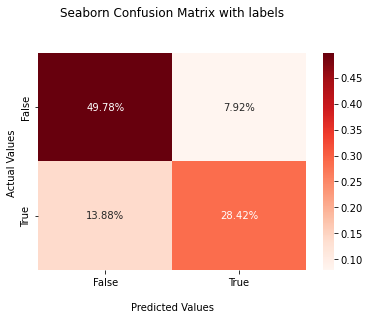

In [98]:
confunsionMatrix(cm)

In [99]:
report = classification_report(y_test, predictions, digits=5) # precision and recall and accuracy
print(report)

              precision    recall  f1-score   support

           0    0.78198   0.86267   0.82035      1318
           1    0.78193   0.67184   0.72272       966

    accuracy                        0.78196      2284
   macro avg    0.78195   0.76726   0.77153      2284
weighted avg    0.78196   0.78196   0.77905      2284



In [100]:
# try 5
# countvectorize + LogisticRegression

In [101]:
cv = CountVectorizer(stop_words = 'english')
X_train_5 = cv.fit_transform(X_train)
X_test_5 = cv.transform(X_test)

In [102]:
clf = LogisticRegression(random_state = seed, max_iter = 1000)
parameters = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

clf_lr = GridSearchCV(clf, parameters, cv = 5, n_jobs=-1).fit(X_train_5, y_train)

In [103]:
predictions = clf_lr.predict(X_test_5.toarray())

In [104]:
cm = metrics.confusion_matrix(y_test, predictions) 

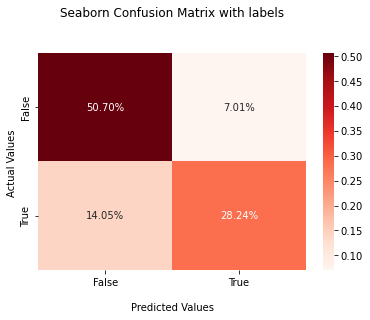

In [105]:
confunsionMatrix(cm)

In [106]:
report = classification_report(y_test, predictions, digits=5) # precision and recall and accuracy
print(report)

              precision    recall  f1-score   support

           0    0.78296   0.87860   0.82803      1318
           1    0.80124   0.66770   0.72840       966

    accuracy                        0.78940      2284
   macro avg    0.79210   0.77315   0.77822      2284
weighted avg    0.79069   0.78940   0.78589      2284



In [107]:
# try 6
# countvectorize + SVM

In [108]:
cv = CountVectorizer(stop_words = 'english')
X_train_6 = cv.fit_transform(X_train)
X_test_6 = cv.transform(X_test)

In [109]:
svc = SVC(random_state = seed, probability = True, verbose = True)
parameters = {'C':[1,2,3,4,5,8,9,10], 'kernel': ['poly', 'rbf'], 'cache_size': [1000]}

clf_svc = GridSearchCV(svc, parameters, cv = 5, n_jobs=-1).fit(X_train_6, y_train)

[LibSVM]

In [110]:
predictions = clf_svc.predict(X_test_6.toarray())

In [111]:
cm = metrics.confusion_matrix(y_test, predictions) 

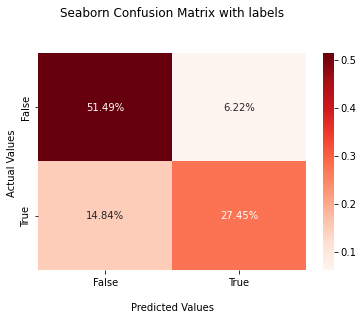

In [112]:
confunsionMatrix(cm)

In [113]:
report = classification_report(y_test, predictions, digits=5) # precision and recall and accuracy
print(report)

              precision    recall  f1-score   support

           0    0.77624   0.89226   0.83022      1318
           1    0.81534   0.64907   0.72277       966

    accuracy                        0.78940      2284
   macro avg    0.79579   0.77066   0.77649      2284
weighted avg    0.79278   0.78940   0.78477      2284



In [114]:
# best model was try 1

In [115]:
# preparing test set

In [116]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [117]:
# removing emojis
test['text'] = test['text'].apply(removing_emoji)

In [118]:
# counting pontuactio per tweet

test['count_punct'] = test.text.apply(lambda s: count(s, string.punctuation))

In [119]:
# remove ponctuation and set lower case

text_list = list(test['text'])

clear_text_list = [] 

for i in tqdm(range(len(text_list))):
    clear_text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',text_list[i])
    #re.sub 
    clear_text_list.append(clear_text.lower())
    #lower
    
test['clear_text'] = clear_text_list

100%|██████████| 3263/3263 [00:00<00:00, 326253.64it/s]


In [120]:
# spellchecking

test['clear_text_corrected'] = test['clear_text'].apply(correct_spellings)

In [121]:
# Counting stopwords

test['stopwords'] = test['clear_text_corrected'].str.split().apply(lambda x: len(set(x) & stop))

In [122]:
# counting words per tweet

test['totalwords'] = test['clear_text_corrected'].str.split().str.len()

In [123]:
# Replacing missing values in keyword and location

test['keyword'] = test['keyword'].fillna('none')
test['location'] = test['location'].fillna('unknown')

In [124]:
test.head()

,id,keyword,location,text,count_punct,clear_text,clear_text_corrected,stopwords,totalwords
0,0,none,unknown,Just happened a terrible car crash,0,just happened a terrible car crash,just happened a terrible car crash,2,6
1,2,none,unknown,"Heard about #earthquake is different cities, s...",3,heard about earthquake is different cities sta...,heard about earthquake is different cities sta...,2,9
2,3,none,unknown,"there is a forest fire at spot pond, geese are...",2,there is a forest fire at spot pond geese are ...,there is a forest fire at spot pond geese are ...,9,19
3,9,none,unknown,Apocalypse lighting. #Spokane #wildfires,3,apocalypse lighting spokane wildfires,apocalypse lighting spokane wildfires,0,4
4,11,none,unknown,Typhoon Soudelor kills 28 in China and Taiwan,0,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kills 28 in china and taiwan,2,8


In [125]:
# new test dataset

df_test = test[['keyword', 'location', 'stopwords', 'totalwords', 'count_punct', 'clear_text_corrected']]

In [126]:
df_test.head()

,keyword,location,stopwords,totalwords,count_punct,clear_text_corrected
0,none,unknown,2,6,0,just happened a terrible car crash
1,none,unknown,2,9,3,heard about earthquake is different cities sta...
2,none,unknown,9,19,2,there is a forest fire at spot pond geese are ...
3,none,unknown,0,4,3,apocalypse lighting spokane wildfires
4,none,unknown,2,8,0,typhoon soudelor kills 28 in china and taiwan


In [127]:
df_test = df_test['keyword'] + ' ' + df_test['location'] + ' ' + df_test['stopwords'].apply(str) + ' ' + df_test['totalwords'].apply(str) + ' ' + df_test['count_punct'].apply(str) + ' ' + df_test['clear_text_corrected']

In [128]:
df_test.head()

0    none unknown 2 6 0 just happened a terrible ca...
1    none unknown 2 9 3 heard about earthquake is d...
2    none unknown 9 19 2 there is a forest fire at ...
3    none unknown 0 4 3 apocalypse lighting spokane...
4    none unknown 2 8 0 typhoon soudelor kills 28 i...
dtype: object

In [129]:
# Try_3 model again

tfidf_vectorizer = TfidfVectorizer(stop_words="english")
X_train_3 = tfidf_vectorizer.fit_transform(X_train)
X_test_3 = tfidf_vectorizer.transform(X_test)

In [130]:
svc = SVC(random_state = seed, probability = True, verbose = True)
parameters = {'C':[1,2,3,4,5,8,9,10], 'kernel': ['poly', 'rbf'], 'cache_size': [1000]}

clf_svc = GridSearchCV(svc, parameters, cv = 5, n_jobs=-1).fit(X_train_3, y_train) #.values.ravel())

[LibSVM]

In [131]:
# try_3 model on the Test data

In [132]:
X_df_test = tfidf_vectorizer.transform(df_test)

In [133]:
predictions = clf_NB.predict(X_df_test)
print("Predicted disaster :",predictions)

Predicted disaster : [0 1 1 ... 1 1 1]


In [134]:
my_submission = pd.DataFrame(columns= ['Id', 'target'])
my_submission['Id'] = test.id
my_submission['target'] = predictions
# you could use any filename. We choose submission here
my_submission.to_csv('Disaster_tweets_submission.csv', index=False)

In [135]:
# submiting this results in the kaggle competition results in a scored of 0.77321
# Its bad

In [136]:
# USING BERT

In [137]:
import tensorflow as tf

In [138]:
X = df_train['keyword'] + ' ' + df_train['location'] + ' ' + df_train['stopwords'].apply(str) + ' ' + df_train['totalwords'].apply(str) + ' ' + df_train['count_punct'].apply(str) + ' ' + df_train['clear_text_corrected']
y = df_train['target']

#X = df_train['clear_text_corrected']

In [139]:
X.head()

0    none unknown 6 13 1 deeds reason earthquake ma...
1    none unknown 0 7 1 forest fire near la range a...
2    none unknown 9 22 3 residents asked shelter pl...
3    none unknown 1 8 2 13000 people receive wildfi...
4    none unknown 6 16 2 got sent photo ruby alaska...
dtype: object

In [140]:
AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 3
BATCH_SIZE = 16
MAX_LEN = 256

In [141]:
from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [142]:
x_train = tokenizer(
text = X.tolist(),
    add_special_tokens = True,
    max_length = 34,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
    
)

target = y.values

In [143]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [144]:
max_len = 34

from tensorflow.keras.layers import Input, Dense 

input_ids = Input(shape = (max_len,), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len,), dtype = tf.int32, name = 'input_mask')

embeddings = bert([input_ids, input_mask])[1]

out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [145]:
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [146]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'input_mask':x_train['attention_mask']} ,
    y = df_train.target,
    validation_split = 0.3,
    epochs=6,
    batch_size=10
)

Epoch 1/6


c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


533/533 [==============================] - 721s 1s/step - loss: 0.5493 - accuracy: 0.7454 - val_loss: 0.4863 - val_accuracy: 0.7789
Epoch 2/6
533/533 [==============================] - 685s 1s/step - loss: 0.4595 - accuracy: 0.8007 - val_loss: 0.4649 - val_accuracy: 0.7933
Epoch 3/6
533/533 [==============================] - 676s 1s/step - loss: 0.4434 - accuracy: 0.8090 - val_loss: 0.4459 - val_accuracy: 0.8060
Epoch 4/6
533/533 [==============================] - 1687s 3s/step - loss: 0.4355 - accuracy: 0.8129 - val_loss: 0.4742 - val_accuracy: 0.7942
Epoch 5/6
533/533 [==============================] - 685s 1s/step - loss: 0.4190 - accuracy: 0.8225 - val_loss: 0.4544 - val_accuracy: 0.8060
Epoch 6/6
533/533 [==============================] - 689s 1s/step - loss: 0.4139 - accuracy: 0.8274 - val_loss: 0.4521 - val_accuracy: 0.8065


In [147]:
x_test = tokenizer(
    text=df_test.tolist(),
    add_special_tokens=True,
    max_length=34,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [148]:
x_test['attention_mask']

<tf.Tensor: shape=(3263, 34), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>

In [149]:
predicted = model.predict({'input_ids':x_test['input_ids'],'input_mask':x_test['attention_mask']})

102/102 [==============================] - 70s 666ms/step


In [150]:
#df_sample = pd.read_csv('sample_submission.csv')

In [151]:
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample = pd.DataFrame(columns= ['Id', 'target'])
df_sample['id'] = test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)

In [152]:
# Using this BERT the Kaggle score is 0.79619 

In [153]:
# end